# Benchmarks

In this chapter, we provide rudimentary benchmarks of the Python bindings to fftwpp. The timings reported in the plot where produced on a Intel® Core™ i9-9880H CPU @ 2.30GHz with 32 Go of RAM. No particular precautions were taken regarding the load of the machine.

In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt

import pyfftwpp
from pyfftwpp import PlanFactory

plt.rcParams["figure.figsize"] = (8, 6)

This function should be called if you intend to use the multi-threaded implementation of FFTW.

In [2]:
pyfftwpp.init_threads();

## NumPy vs. FFTW: 1D benchmark

We consider 1D transforms of increasing size and compare NumPy and FFTW (single thread)

In [3]:
rng = np.random.default_rng(202103271821)

In [4]:
rank = 1
sizes = [1 << k for k in range(14)]

timeit_params = {"repeat": 10, "number": 100000}

# - row 0: size of 1D fft
# - row 1: average time, numpy implementation
# - row 2: standard deviation, numpy implementation
# - row 3: average time, fftw
# - row 4: standard deviation, fftw
data = np.empty((len(sizes), 5), dtype=np.float64)

pyfftwpp.plan_with_nthreads(1)
factory = PlanFactory().set_measure()

for i, size in enumerate(sizes):
    data[i, 0] = size
    real = rng.random(size=rank * (size,), dtype=np.float64)
    imag = rng.random(size=real.shape, dtype=real.dtype)
    a = real + 1j * imag

    t = timeit.repeat("np.fft.fft(a)", globals=globals(), **timeit_params)
    data[i, 1:3] = np.mean(t), np.std(t)

    x = np.empty_like(a)
    y = np.empty_like(a)
    plan = factory.create_plan(1, x, y)
    x[:] = a

    t = timeit.repeat("plan.execute()", globals=globals(), **timeit_params)
    data[i, 3:] = np.mean(t), np.std(t)

Text(0.5, 1.0, '1D, complex-to-complex FFT')

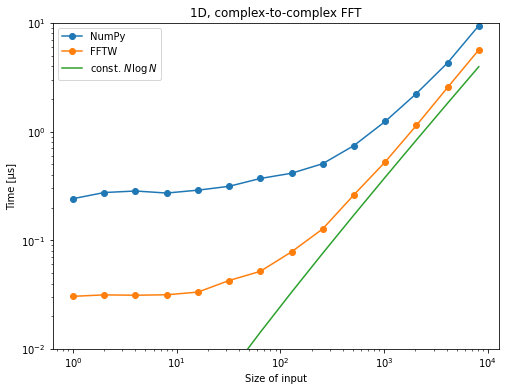

In [5]:
const = 0.7 * data[-1, 3] / (data[-1, 0] * np.log(data[-1, 0]))

plt.loglog(sizes, data[:, 1], "o-", label="NumPy")
plt.loglog(sizes, data[:, 3], "o-", label="FFTW")
plt.loglog(
    sizes, sizes * np.log(sizes) * const, "-", label=r"$\mathrm{const.}\,N\log N$"
)
plt.legend()
plt.ylim(1e-2, 1e1)
plt.xlabel("Size of input")
plt.ylabel("Time [μs]")
plt.title("1D, complex-to-complex FFT")

Both NumPy and FFTW exhibit the expected $\mathcal O(N\log N)$ complexity. The single-threaded implementation of FFTW is already significantly faster than NumPy.

In [6]:
np.savetxt("numpy_vs_fftw_1d.csv", data)

## Scaling of the multithreaded version: 3D transforms

We now consider 3D transforms of size 81 (we avoid powers of 2 here) and increase the number of threads.

In [7]:
rank = 3
size = 81

timeit_params = {"repeat": 10, "number": 1000}

# - row 0: number of threads
# - row 0: average time, numpy implementation
# - row 1: standard deviation, numpy implementation
data2 = []

factory = PlanFactory().set_measure()

for i, num_threads in enumerate(range(1, 17)):
    real = rng.random(size=rank * (size,), dtype=np.float64)
    imag = rng.random(size=real.shape, dtype=real.dtype)
    a = real + 1j * imag

    x = np.empty_like(a)
    y = np.empty_like(a)
    pyfftwpp.plan_with_nthreads(num_threads)
    plan = factory.create_plan(1, x, y)
    x[:] = a

    t = timeit.repeat("plan.execute()", globals=globals(), **timeit_params)
    data2.append((num_threads, np.mean(t), np.std(t)))

data2 = np.array(data2, dtype=np.float64)

Text(0.5, 1.0, '(81, 81, 81), complex-to-complex, multithreaded, FFT')

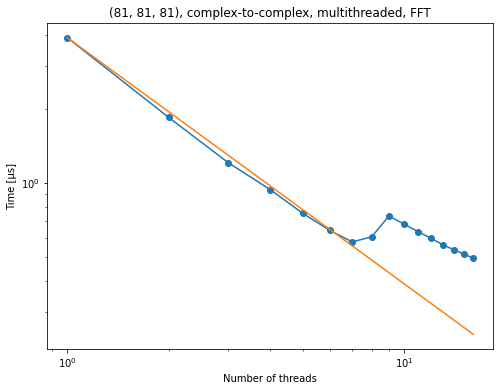

In [8]:
plt.loglog(data2[:, 0], data2[:, 1], "o-")
plt.loglog(data2[:, 0], data2[0, 0] / data2[:, 0] * data2[0, 1])
plt.xlabel("Number of threads")
plt.ylabel("Time [μs]")
plt.title(f"{rank * (size,)}, complex-to-complex, multithreaded, FFT")

We observe almost perfect scaling up to 7 threads, which appears to be the optimum for this machine.

In [9]:
np.savetxt(f"fftw_openmp_{size}_{rank}d.csv", data2)